# Train Diffusion Model
### Imports

In [1]:
try: 
    import librosa
except:
    !pip install librosa


#Set Dir 
import sys, os
sys.path.append(os.path.abspath('..'))

# Torch
import torch
from torch import nn, Tensor
from torch.utils.data import DataLoader, Subset
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms

# Utils
import numpy as np
from numpy import ndarray
import logging

# Base Scripts
from Libraries.U_Net import *
from Libraries.Diffusion import *
from Libraries.Utils import *
from MainScripts.Conf import conf

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 260.7/260.7 kB 19.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 403.7/403.7 kB 44.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.8/3.8 MB 72.3 MB/s eta 0:00:00:00:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 64.6/64.6 kB 12.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 76.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 252.5/252.5 kB 37.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 42.4/42.4 MB 31.5 MB/s eta 0:00:00:00:0100:01


### Config
General

In [2]:
remote_kernel: bool = True

logging_level: int = logging.INFO
model_name: str = "diffusion_mnist_v6"
full_model_path: str = path_to_remote_path("{}/{}".format(conf["paths"].model_path, model_name + ".pth"), remote_kernel)
checkpoint_freq: int = 10 #0 for no checkpoint saving
training_data_name: str = "training_full_low_res"

device = "cuda" if torch.cuda.is_available() else "cpu"
restart_training: bool = True #If True and model already exists optimizer and lr_scheduler are reset
learning_rate: float = 5e-4 #Starting lr/first lr for Threshold Scheduler
epochs: int = 200
n_training_samples: int = 10000
tensor_dim: list = [8, 1, 32, 32] #B, C, H, W

logging.basicConfig(level=logging_level, format='%(asctime)s - %(levelname)s - %(message)s')
logger: logging.Logger = logging.getLogger(__name__)

### Data Loading

In [3]:
file: ndarray = load_training_data(path_to_remote_path("{}/{}".format(conf["paths"].data_path, training_data_name + ".npy"), remote_kernel))[:n_training_samples, ...]
data_loader = create_dataloader(Audio_Data(file), tensor_dim[0])
logger.info(f"Data loaded with shape: {file.shape}")

2025-05-19 19:12:38,254 - INFO - Data loaded with shape: (7087, 224, 416)


In [9]:
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Grayscale(num_output_channels=1), 
])

cifar10_train = torchvision.datasets.CIFAR10(
    root=path_to_remote_path(conf["paths"].data_path, remote_kernel), 
    train=True, 
    download=True, 
    transform=transform
)
indices = np.random.choice(len(cifar10_train), size=n_training_samples, replace=False)
cifar10_subset = Subset(cifar10_train, indices)
data_loader = DataLoader(cifar10_subset, batch_size=tensor_dim[0], shuffle=False)

Files already downloaded and verified


In [3]:
transform = transforms.Compose([
    transforms.Resize((32, 32)),
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))
])

mnist_train = torchvision.datasets.MNIST(
    root='./data',        
    train=True,
    transform=transform,
    download=True
)
indices = np.random.choice(len(mnist_train), size=n_training_samples, replace=False)
mnist_subset = Subset(mnist_train, indices)
data_loader = DataLoader(mnist_subset, batch_size=tensor_dim[0], shuffle=False)

### Model Creation
#### U-Net

Small U-Net

In [4]:
u_net = U_NET(in_channels=1,
            channels=[16, 32, 32],
            res_blocks=[1, 1, 2],
            factors=[2, 2, 2],
            attentions=[0, 1, 1], 
            attention_heads=12,
            attention_features=64,
            activation=nn.GELU(), 
            embeding_dim=conf["model"].time_embed_dim, 
            embed_class=Simple_Embed,
            device=device
            ).to(device)

Large U-Net

In [14]:
u_net = U_NET(in_channels=1,
            channels=[64, 128, 256, 512],
            res_blocks=[12, 2, 2, 2],
            factors=[ 2, 2, 2, 2],
            attentions=[ 0, 0, 0, 1], 
            attention_heads=8,
            attention_features=48,
            activation=nn.GELU(), 
            embeding_dim=conf["model"].time_embed_dim, 
            device=device
            ).to(device)

U-Net loading if possible

In [5]:
ema = EMA(u_net, decay = 0.99)
optimizer = optim.AdamW(u_net.parameters(), lr=learning_rate)
#scheduler = Threshold_LR(optimizer, [1, 0.1, 0.09, 0.85, 0.08, 0.07], [learning_rate, 1e-4, 1e-5, 5e-6, 1e-6, 1e-7])
scheduler = optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=epochs)
start_epoch: int = 0
if os.path.exists(full_model_path):
    model = torch.load(full_model_path, map_location=device)
    u_net.load_state_dict(model["model"])
    if 'ema_state' in model:
        for name, param in model.named_parameters():
            if param.requires_grad and name in model['ema_state']:
                ema.shadow[name] = model['ema_state'][name].clone()
    if not restart_training:
        optimizer.load_state_dict(model["optim"])
        scheduler.load_state_dict(model["scheduler"])
        start_epoch = model.get("epoch", 0)
    logger.info(f"Model {model_name} loaded with {count_parameters(u_net)} Parameters")
else: 
    logger.info(f"Model {model_name} created with {count_parameters(u_net)} Parameters")

2025-05-21 11:16:32,962 - INFO - Model diffusion_mnist_v6 loaded with 682658 Parameters


Save Architecture

In [6]:
u_net.eval()
with torch.no_grad():
    example_x = torch.randn(*tensor_dim).to(device)
    example_t = torch.randint(0, 500, (tensor_dim[0],), dtype=torch.long).to(device)
    script_model = torch.jit.trace(u_net,(example_x, example_t), check_trace=False)
torch.jit.save(script_model, path_to_remote_path("{}/{}".format(conf["paths"].result_path, model_name + ".pt"), remote_kernel))

Diffusion

In [6]:
diffusion = Diffusion(model=u_net, 
                        noise_steps=conf["model"].diffusion_timesteps, 
                        noise_schedule="cosine", 
                        input_dim=tensor_dim,
                        ema = None,
                        device=device
)

### Train

In [9]:
x, _ = diffusion.train(epochs=epochs, 
                    data_loader=data_loader, 
                    loss_function=nn.MSELoss(),
                    optimizer=optimizer, 
                    lr_scheduler=scheduler, 
                    gradient_accum=1,
                    checkpoint_freq=10, 
                    model_path=full_model_path, 
                    start_epoch=start_epoch,
                    patience=100,
                    ema_freq=0
                )
scatter_plot(x)

2025-05-19 17:27:52,579 - INFO - Training started on cuda
2025-05-19 17:31:20,120 - INFO - Epoch 001: Avg. Loss: 4.20215e-01 Remaining Time: 11h 28min 20s LR: 4.99969e-04 
2025-05-19 17:34:46,447 - INFO - Epoch 002: Avg. Loss: 3.32958e-01 Remaining Time: 11h 22min 52s LR: 4.99877e-04 
2025-05-19 17:38:12,780 - INFO - Epoch 003: Avg. Loss: 3.25816e-01 Remaining Time: 11h 18min 46s LR: 4.99722e-04 
2025-05-19 17:41:39,105 - INFO - Epoch 004: Avg. Loss: 3.22588e-01 Remaining Time: 11h 14min 59s LR: 4.99507e-04 
2025-05-19 17:45:05,493 - INFO - Epoch 005: Avg. Loss: 3.19578e-01 Remaining Time: 11h 11min 23s LR: 4.99229e-04 
2025-05-19 17:48:31,830 - INFO - Epoch 006: Avg. Loss: 3.18607e-01 Remaining Time: 11h 07min 48s LR: 4.98890e-04 
2025-05-19 17:51:58,117 - INFO - Epoch 007: Avg. Loss: 3.15881e-01 Remaining Time: 11h 04min 15s LR: 4.98490e-04 
2025-05-19 17:55:24,523 - INFO - Epoch 008: Avg. Loss: 3.15836e-01 Remaining Time: 11h 00min 46s LR: 4.98029e-04 
2025-05-19 17:58:51,144 - INFO

: 

In [9]:
#x: ndarray = diffusion.bwd_diffusion_ddim(n_samples=8, sampling_timesteps=200, eta = 0.2)
x: ndarray = diffusion.bwd_diffusion_ddpm(n_samples=8)

2025-05-21 11:18:22,841 - INFO - Started sampling 8 samples
2025-05-21 11:19:51,785 - INFO - Created 8 samples


-1617.2284 747.0795


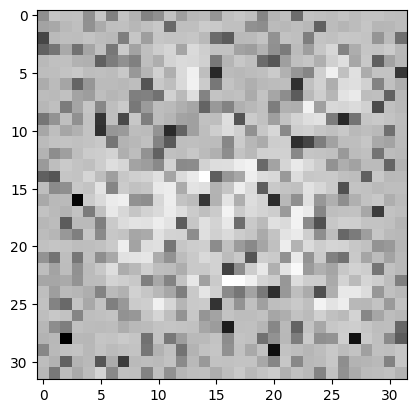

-1792.8938 814.3847


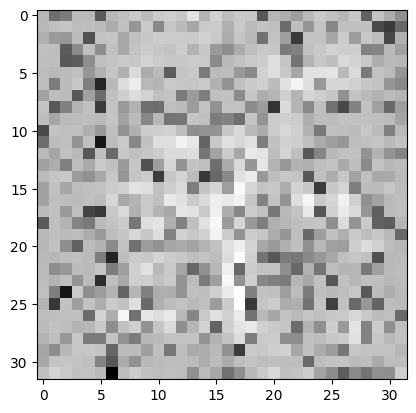

-1870.1311 727.17236


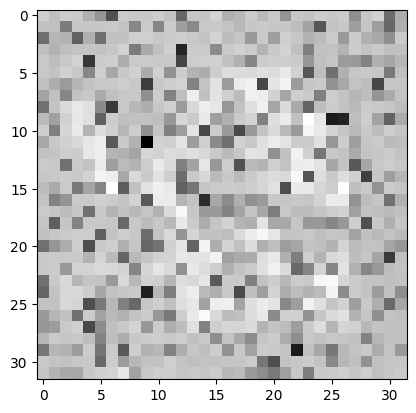

-2031.4391 844.2638


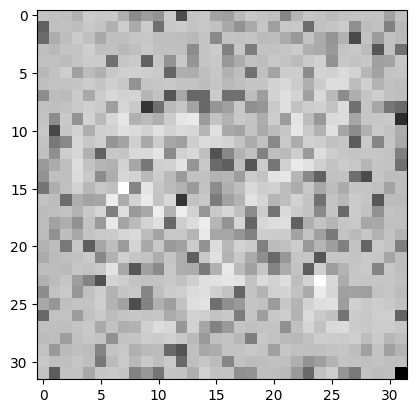

-1592.7039 805.4926


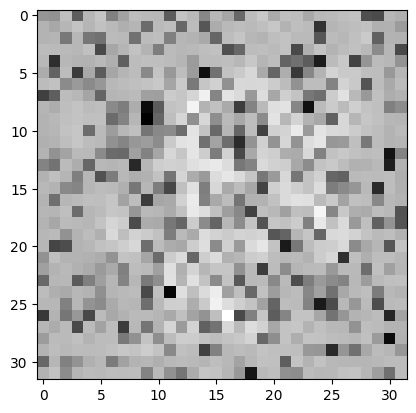

-1500.2096 716.2033


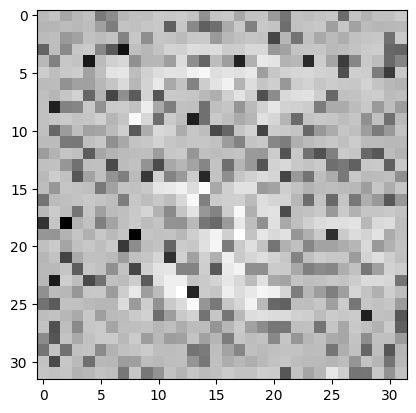

-1982.103 749.83044


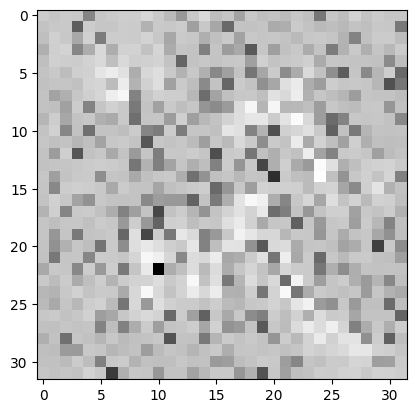

-1748.7238 805.3837


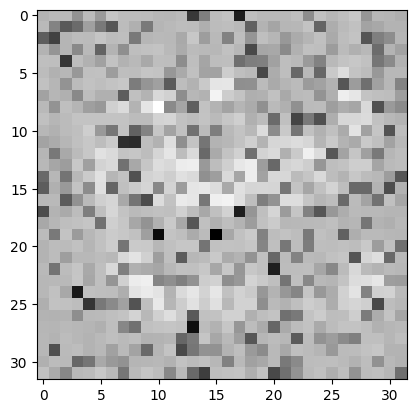

In [8]:
for i in range(x.shape[0]):
    print(np.min(x[i,0]), np.max(x[i,0]), flush=True)
    plt.imshow(normalize(x[i,0], -1, 1), cmap="gray")
    plt.show()